# Load Data

In [1]:
import pandas as pd
import numpy as np
import os

## If in Google Colab:

In [5]:
# Get the current directory of the Jupyter notebook
current_directory = os.path.realpath('data.py')

# Navigate to the parent directory
parent_directory = os.path.dirname(current_directory)

# Read the CSV file using pandas
data_goemotions = pd.read_csv(os.path.join(parent_directory,'..', 'data','raw','GoEmotions_full_raw.csv'))
data_abbreviations = pd.read_csv(os.path.join(parent_directory, '..', 'data','raw','Abbreviations_and_Slang.csv'))
data_slangs = pd.read_csv(os.path.join(parent_directory, '..', 'data','raw','slang.csv'))[['acronym', 'expansion']]

# Display the first 3 rows of the DataFrame
data_goemotions.head(3)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [2]:
# !pip install unidecode
# from google.colab import drive
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# drive.mount('/content/drive') # Mounting drive path

In [3]:
# data_goemotions = pd.read_csv('/content/drive/MyDrive/human_vs_twitter/full_dataset/GoEmotions_full_raw.csv')
# data_abbreviations = pd.read_csv('/content/drive/MyDrive/human_vs_twitter/Abbreviations and Slang.csv')
# data_slangs = pd.read_csv('/content/drive/MyDrive/human_vs_twitter/slang.csv')[['acronym', 'expansion']]

# if in Jupyter Notebook

In [36]:
data_goemotions = pd.read_csv('../data/raw/GoEmotions_full_raw.csv')
data_abbreviations = pd.read_csv('../data/raw/Abbreviations_and_Slang.csv')
data_slangs = pd.read_csv('../data/raw/slang.csv')[['acronym', 'expansion']]

# Data preprocessing

## Slang Translation

In [27]:
# Concatenating slang and abbreviation datasets
data_slangs.rename(columns = {'acronym':'Abbreviations','expansion':'Text'}, inplace = True)
data_slang_all = pd.concat([data_abbreviations , data_slangs], axis=0)

# Drop duplicates and null values
data_slang_all.drop_duplicates(inplace=True)
data_slang_all.dropna

# Checking
print(f'Data + Slang full dataset shape: {data_slang_all.shape}')
print(f'Data + Slang full dataset null: {data_slang_all.isnull().sum()[0]}')
print(f'Data + Slang full dataset duplicates: {data_slang_all.duplicated().sum()}')

Data + Slang full dataset shape: (3314, 2)
Data + Slang full dataset null: 0
Data + Slang full dataset duplicates: 0


/tmp/ipykernel_16198/1997835365.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Data + Slang full dataset null: {data_slang_all.isnull().sum()[0]}')


**Transforming DF into dict for mapping:**

In [29]:
# Transforming DF into dict for mapping

slang_dict = dict(zip(data_slang_all.Abbreviations, data_slang_all.Text))

## Creating Slang Translation class

In [30]:
import string

class SlangTranslation:

  def __init__(self, col):

    self.col = col

  def remove_punctuation(self, txt):
    """Iterates through each word of the string and removes punctuation"""
    txt = txt.lower()

    for punctuation in string.punctuation:
        txt = txt.replace(punctuation, ' ')

    return txt

  def string_translator(self, txt):
    """Iterates through each word of the string and translates them"""

    txt = ' '.join([slang_dict.get(i, i) for i in txt.split()])

    return txt

  def apply_translator(self):
    """Takes the text column as input, outputs the same column translated."""

    txt = self.col.apply(self.remove_punctuation)

    txt = txt.apply(self.string_translator)

    return txt

# Preprocessing

In [31]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

## Creating PreprocessingText Class

In [32]:
class PreprocessingText:

    def __init__(self, col):
        self.col = col

    def cleaning_text(self, txt):
        """
        Transform everything in lowercase, strip the text and remove everything that's not letters or space
        """
        txt = txt.lower()
        txt = txt.replace('’', '').strip()
        text_cleaned = ''.join(filter(lambda x: x.isalpha() or x.isspace(), txt)) # Remove everything that's not letters or space

        return text_cleaned

    def tokenizing_text(self, txt):
        """
        Create stopword list, tokenize the words and return the text tokenized without stopwords
        """
        stop_words = set(stopwords.words('english')) # Create stopword list
        tokenized = word_tokenize(txt) # Tokenize
        tokenized_text = [word for word in tokenized if not word in stop_words] # Tokenizing text

        return tokenized_text

    def lemmatizing_text(self, tokenized_txt):
        """
        Lemmatize the text and return a cleaned sentence
        """
        lemmatized = [
            WordNetLemmatizer().lemmatize(word, pos='v') for word in tokenized_txt
        ] # Lematize
        cleaned_sentence = " ".join(word for word in lemmatized) # Lemmatized text

        return cleaned_sentence

    def apply_preprocessor(self):
        """
        Apply all functions above and drop 'na' values
        """
        txt = self.col
        txt = txt.apply(self.cleaning_text)
        txt = txt.apply(self.tokenizing_text)
        txt = txt.apply(self.lemmatizing_text)
        txt = txt.dropna()

        return txt

## Applying Preprocessor on GoEmotion 'text' column

In [33]:
# Applying the slang translation

data_goemotions['text'] = SlangTranslation(data_goemotions['text']).apply_translator()

df_preprocessed = data_goemotions

df_preprocessed['text'] = PreprocessingText(df_preprocessed['text']).apply_preprocessor()

In [39]:
df_preprocessed['text'][16]

'well id say pretty good chance girl laugh loud'

# Train test split

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X = df_preprocessed['text']
y = df_preprocessed.drop(columns= 'text')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((166251,), (41563,), (166251, 28), (41563, 28))

## Embedding

In [45]:
from gensim.models import Word2Vec
import gensim.downloader
from keras.preprocessing.sequence import pad_sequences

In [14]:
#vocab = df_preprocessed['text'].str.split().apply(pd.Series).stack().unique()

### Training word2vec

In [ ]:
# Our own training
word2vec = Word2Vec(sentences=X_train)
wv = word2vec.wv

### Pretrained word2vec

In [46]:
# Pretrained
word2vec = gensim.downloader.load('glove-wiki-gigaword-50')

In [47]:
class EmbeddingText:
    def __init__(self, word2vec):
        """
        Initialize the EmbeddingText with a word2vec model.
        """
        self.word2vec = word2vec

    def embed_sentence(self, sentence):
        """
        Convert a sentence (list of words) into a matrix representing the words in the embedding space.
        """
        embedded_sentence = [self.word2vec[word] for word in sentence if word in self.word2vec]
        return np.array(embedded_sentence)

    def embed_sentences(self, sentences):
        """
        Convert a list of sentences into a list of matrices.
        """
        return [self.embed_sentence(sentence) for sentence in sentences]

In [49]:
embedding_instance = EmbeddingText(word2vec)
X_train_embedded = embedding_instance.embed_sentences(X_train)

In [55]:
assert X_train_embedded[0] ==

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

: 

## Padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [19]:
X_pad = pad_sequences(X_train_embedded, dtype='float32', padding='pre')

## Exporting to CSV

### Colab

In [ ]:
#df_preprocessed.to_csv('/content/drive/MyDrive/human_vs_twitter/data/preprocessed/data_preprocessed.csv')

### Notebook

In [11]:
df_preprocessed.to_csv('../data/preprocessed/data_preprocessed.csv')

# Data Exploration

In [20]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Get the current directory of the Jupyter notebook
current_directory = os.path.realpath('human_vs_twitter.ipynb')

# Navigate to the parent directory
parent_directory = os.path.dirname(current_directory)

# Construct the path to the CSV file in the 'data' folder
file_path = os.path.join( parent_directory, '..', 'data','raw','GoEmotions_full_raw.csv')

# Read the CSV file using pandas
df = pd.read_csv(file_path)

# Display the first 3 rows of the DataFrame
df.head(3)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [34]:
class_counts = df.drop(['text'],axis=1).sum(axis=0)
class_counts_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})

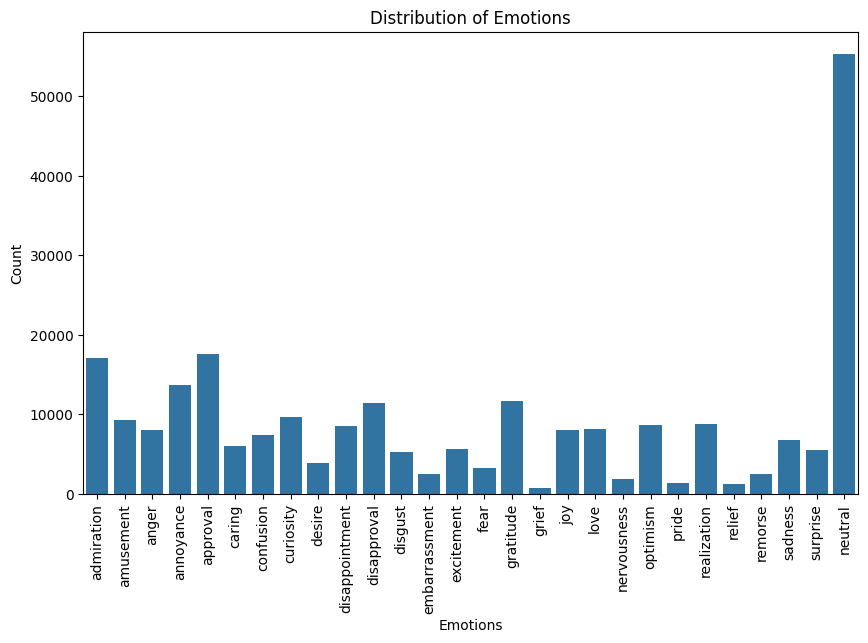

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

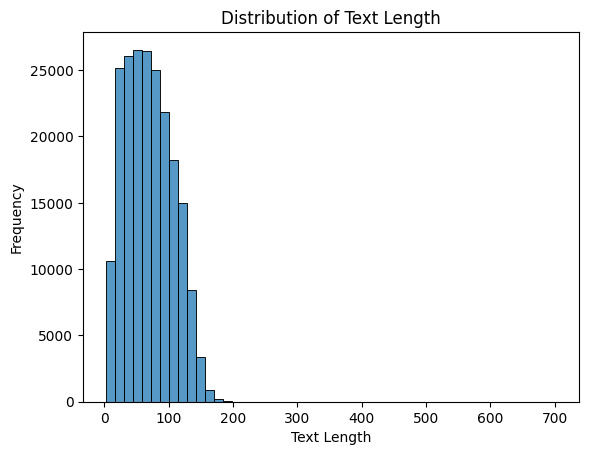

In [38]:
df['text_length'] = df['text'].apply(len)
#plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Model

## Dummy model

In [39]:
dummy_model = df_preprocessed.drop('text', axis = 1)
dummy_model = np.floor((np.floor(dummy_model.sum())*100)/np.floor(len(dummy_model)))['neutral']

print(f'Dummy model accuracy: 0.{dummy_model}')

## Test model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
# Set parameters
input_shape = X_pad.shape[1:]# Maximum feature length
loss = 'categorical_crossentropy' # Loss function
optimizer= 'adam'  # Optimizer
metrics= ['accuracy']  # Defining metric to accuracy

In [25]:
def init_model():
    """Function to create model architecture"""
    model = Sequential() # Instanciate the model
    # model.add(Embedding(max_features, input_length=max_len, output_dim = 28)) # Embedding
    model.add(LSTM(neurons=64, activation='tanh', input_shape = input_shape)) # Input layer
    model.add(Dense(neurons=32, activation='tanh')) # Hidden layer
    model.add(Dense(neurons=32, activation='tanh')) # Hidden layer
    model.add(Dense(neurons=28, activation='softmax')) # Output layer

    return model

In [26]:
def compile_model(model):
    """Function to compile the model"""
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )
    return model

In [27]:
model = init_model()
model = compile_model(model)

In [32]:
es = EarlyStopping(patience=3)

In [33]:
history = model.fit(
    X_pad,
    y_train,
    batch_size=264,
    epochs=500,
    validation_split=0.2,
    callbacks=[es]
)

Epoch 1/100
4/4 [==============================] - 5s 775ms/step - loss: 3.6379 - accuracy: 0.2438 - val_loss: 3.7626 - val_accuracy: 0.2400
Epoch 2/100
4/4 [==============================] - 2s 409ms/step - loss: 3.6220 - accuracy: 0.2438 - val_loss: 3.7659 - val_accuracy: 0.2400
Epoch 3/100


KeyboardInterrupt: 

## Model Tuning

In [1]:
# We are going to do hyperparameter tuning to find the best model.

# This returns the LSTM model in Keras.
def get_keras_model(lstm_units,
                    neurons_dense,
                    dropout_rate,
                    input_shape):
    # define the layers.

    inputs = tensorflow.keras.Input(shape=(input_shape,))
    x = LSTM(units=lstm_units)(x)
    x = Dense(neurons_dense, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons_dense, activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(28, activation="softmax")(x)
    model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
    return model


# This function takes in the hyperparameters and returns a score (Cross validation).
def keras_cv_score(parameterization, weight=None):

    max_text_len = parameterization.get('max_text_len')

    tensorflow.keras.backend.clear_session()
    model = get_keras_model(parameterization.get('lstm_units'),
                            parameterization.get('neurons_dense'),
                            parameterization.get('dropout_rate'),
                            parameterization.get('embedding_size'),
                            max_text_len)

    learning_rate = parameterization.get('learning_rate')
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)

    NUM_EPOCHS = parameterization.get('num_epochs')



    # Specify the training configuration.
    model.compile(optimizer=optimizer,
                  loss=tensorflow.keras.losses.BinaryCrossentropy(),
                  metrics=[tensorflow.keras.metrics.AUC()])

    # pad the sequences so they're the same length.
    X_train_seq_padded = pad_sequences(X_train)
    X_test_seq_padded  = pad_sequences(X_test)

    # fit the model using a 20% validation set.
    res = model.fit(x=X_train_seq_padded,
                    y=y_train,
                    batch_size=parameterization.get('batch_size'),
                    epochs=NUM_EPOCHS,
                    validation_data=(X_test_seq_padded, y_test))

    last_score = np.array(res.history['val_auc'][-1:])
    return last_score, 0

In [ ]:
parameters=[
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [0.0001, 0.1], # 0.001 / 0.01 / 0.1
        "log_scale": True,
    },
    {
        "name": "dropout_rate",
        "type": "range",
        "bounds": [0.01, 0.5], # 0.1, 0.3, 0.5
        "log_scale": True,
    },
    {
        "name": "lstm_units",
        "type": "range",
        "bounds": [1, 10], # 64
        "value_type": "int"
    },
    {
        "name": "neurons_dense",
        "type": "range",
        "bounds": [1, 300], # 32, 64
        "value_type": "int"
    },
    {
        "name": "num_epochs",
        "type": "range",
        "bounds": [1, 20], # 100, 200
        "value_type": "int"
    },
    {
        "name": "batch_size",
        "type": "range",
        "bounds": [8, 64], # 128, 1024
        "value_type": "int"
    },
]

In [ ]:
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

ax_client = AxClient()

# create the experiment.
ax_client.create_experiment(
    name="keras_experiment",
    parameters=parameters,
    objective_name='keras_cv',
    minimize=False)

def evaluate(parameters):
    return {"keras_cv": keras_cv_score(parameters)}

In [ ]:
best_parameters, values = ax_client.get_best_parameters()

# the best set of parameters.
for k in best_parameters.items():
    print(k)

print()

# the best score achieved.
means, covariances = values
print(means)